# Fermionic bath code: Box initialization

In [1]:
using SpecialFunctions
using Plots
using QuadGK
using BenchmarkTools
using Roots
using Interact

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-3375135829439172751\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-3746132367209383294\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-3375135829439172751\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

In [2]:
tₑ=1 #electron bandwidth= = σ
tB =3 #bath bandwidth
a1=1  #lattice constant
λ= 1 #system bath coupling
Tₑ=0# electron temperature
Temp_bath= 0.8 #the bath temperature
μ = 1  # chemical potential of the electron
μbath = 1 #chem potential of the bath

#time-simulation parameters
h= 0.1 #the time spacing
Time_max = 30 #the net time
N𝑡=Int(floor(Time_max/h)) #


#volume parameters
sitenum = 15 #gives the no. of sites in the lattice
a2=2*π*(1/(sitenum*a1)) #reciprocal space lattice constant
V_ph = collect(-0.5*sitenum*a2:a2:0.5*a2*(sitenum+1))

16-element Array{Float64,1}:
 -3.141592653589793
 -2.722713633111154
 -2.303834612632515
 -1.8849555921538759
 -1.4660765716752369
 -1.0471975511965979
 -0.6283185307179586
 -0.20943951023931984
  0.2094395102393194
  0.6283185307179586
  1.0471975511965974
  1.4660765716752362
  1.8849555921538759
  2.3038346126325147
  2.7227136331111534
  3.141592653589793

In [3]:
N𝑡

300

 **Block for defining Green's functions and convolutions for the electrons**


In [4]:
fermi = function (e,T,μ)
    return 1/(exp((e-μ)*(1/T))+1)
end

function ϵₑ(k)
    return tₑ*(1-cos(V_ph[k]*a1))           #(1-cos(V_ph[k]*a1))
end


function G₀ᴿ(k,t1,t2)
    if t1>=t2
        return -im*exp(-im*ϵₑ(k)*(t1-t2)*h)
    else
        return 0
    end
end


    #prints 0 for t1<t2

function G₀ᴷ(k,t1,t2,Telectron,μ)
    return -im*tanh((ϵₑ(k)-μ)/(2*Telectron))*exp(-im*ϵₑ(k)*(t1-t2)*h)
end


## Convolution function definition

function Fₑ(k,t₁,t₂)  #### Endpnt left out in the discretized integral, add explicitly
    if t₁>t₂
        list=collect(t₂:t₁)
        sum=0
        sum=sum + Σₑᴿ[t₁,t₂]*Gᴿmatrix[k][t₂,t₂]*(h/2)
        
        for i=t₂+1:t₁-1
            sum = sum + Σₑᴿ[t₁,i]*Gᴿmatrix[k][i,t₂]*h
        end
        
        
        return sum
        
        #sum(t->Σₑᴿ[t₁,t]*Gᴿmatrix[k][t,t₂]*h) #where the hell does the t,t result come in
    elseif t₁==t₂
        return 0
    else
        return "You're convoluting in the opposite direction. Possible error at RR/electron conv"
    end
end

function RKₑ(k,t1,t2) #∫₀ᵗ Σₑᴿ⋅Gᴷ  #there's a crucial endpiece missing viz. the i=t1 piece, needs to be explicitly added
    if t1>1
        sum=0
        sum = sum + Σₑᴿ[t1,1]*Gᴷmatrix[k][1,t2]*(h/2)
        
        for i=2:t1-1
            sum = sum+Σₑᴿ[t1,i]*Gᴷmatrix[k][i,t2]*h
        end
        
        return sum    
        
    else
        return 0
    end
end


function KAₑ(k,t1,t2) #∫₀⋅Gᴿ   ###End pnt included
    if t2>1
        sum=0
        sum=sum+Σₑᴷ[t1,1]* conj(Gᴿmatrix[k][t2,1]) * h*(1/2)  #starting 1/2
        sum=sum+ Σₑᴷ[t1,t2]* conj(Gᴿmatrix[k][t2,t2]) * h*(1/2) #ending 1/2
        
        for i=2:t2-1
            sum=sum+ Σₑᴷ[t1,i]* conj(Gᴿmatrix[k][t2,i]) * h   #middle ones, they get h & not h/2 due to double addition
        end
        
        return sum
            
    else
        return 0
    end
end


KAₑ (generic function with 1 method)

In [5]:
#### Bath definitions

J(ω) = (2/tB)*sqrt( 1- (ω/(2*tB))^2 ) 



function quadgk_cauchy(f, a, c, b)
  fc = f(c)
  g(x) = (f(x) - fc) / (x - c)
  return quadgk(g, a, c, b)[1] + fc * log(abs((b - c)/(a - c)))
end

test(a) =-(λ^2)*J(a)*(1/(2*π))


function reΣ(x)
    if -2*tB<x<2*tB
        return quadgk_cauchy(test, -2*tB, x, 2*tB)

    else
        test2(a,x ) = -(λ^2)*J(a)*(1/(2*π))*(1/(a-x))
        return quadgk(t->test2(t,x), -2*tB,2*tB)[1]
    end
end

function imΣ(ω)
    if abs(ω)<=2*tB
        return -1*(λ^2)*J(ω)*(1/2)
    else
        return 0
    end
end
#imΣ(ω) = -1*(λ^2)*J(ω)*(1/2)


function real_sigmar(t)
    makeshift(ω) = -im*reΣ(ω)*sin(ω*t)*(1/(2*π))
    return quadgk(makeshift,-200*tB,200*tB)[1]
end


function Σᴿ(t1,t2) 
    if t1>t2
        sum1= -im*(λ^2)*(1)*(1/(tB))*( besselj1(2*tB*abs(t1-t2)*h) / (abs(t1-t2)*h ) )
        return sum1
    else
        return 0
    end
end


#-im*(λ^2)*(1)*(1/(tB))*(besselj1(2*tB*abs(t1-t2)*h)/(abs(t1-t2)*h))*(t1>t2)

σᴷ(ω) = -im*(λ^2)*J(ω)*tanh((ω-μbath)/(2*Temp_bath))

function Σᴷ(t1,t2)
    dω=(1/10000)*4*tB
    steps = collect(-2*tB:dω:2*tB)
    result=0
    for ω in steps
        result = result + dω*σᴷ(ω)*exp(-im*ω*(t1-t2)*h)
    end
    return result/(2*π)
end


Σᴷ (generic function with 1 method)

In [6]:
Gᴿmatrix = Array{Array{ComplexF64,2},1}(undef,length(V_ph)+2)

Gᴷmatrix = Array{Array{ComplexF64,2},1}(undef,length(V_ph)+2)

Σₑᴿ = Array{ComplexF64,2}(undef,N𝑡+5,N𝑡+5)

Σₑᴷ = Array{ComplexF64,2}(undef,N𝑡+5,N𝑡+5)

305×305 Array{Complex{Float64},2}:
 0.0+0.0im  0.0+0.0im  0.0+0.0im  …  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  …  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  …  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
    ⋮                             ⋱                        
 0.0+0.0

In [7]:
matinit = function ()
    for i=1:length(V_ph)+2
        Gᴿmatrix[i] = Array{ComplexF64,2}(undef,N𝑡+5,N𝑡+5)
        Gᴷmatrix[i] = Array{ComplexF64,2}(undef,N𝑡+5,N𝑡+5)
    end
end

#8 (generic function with 1 method)

In [8]:

######### Box Initialization ##########
boxinitindex=1

boxinit=function()

    for k =1:length(V_ph)
        for i=1:N𝑡
            Gᴿmatrix[k][i,i] = -im #exactly true           ## Gr(t,t)≂̸0
        end
    end



######## Box Initialization ############

    #GF Initialization

    for k=1:length(V_ph)
        for i=1:boxinitindex
            for j=1:boxinitindex
                Gᴿmatrix[k][i,j] = G₀ᴿ(k,i,j)
                Gᴷmatrix[k][i,j] =  G₀ᴷ(k,i,j,Tₑ,μ)

            end
        end
    end

end

#10 (generic function with 1 method)

# GF updates


In [9]:
totaltime = 10
testrange =Int(floor(10/h)) #200 
matinit()
boxinit()

In [10]:
### Code to update the Sigma R, Sigma K matrix

for i=1:testrange+10
    Σₑᴿ[i,1] = Σᴿ(i,1)
end

for j=2:testrange+10
    for i=j:testrange+10
        Σₑᴿ[i,j] = Σₑᴿ[i-j+1,1]
    end
end

for i=1:testrange+10
    Σₑᴷ[i,1] = Σᴷ(i,1)
end

for i=1:testrange+10
    Σₑᴷ[1,i] = Σᴷ(1,i)
end

for j=1:testrange+10
    for i=j:testrange+10
        Σₑᴷ[i,j] = Σₑᴷ[i-j+1,1]
    end
end

for j=1:testrange+10
    for i=j:testrange+10
        Σₑᴷ[j,i] = Σₑᴷ[1,i-j+1]
    end
end


In [11]:
####### Gr evolution #########

for i=boxinitindex:testrange     ### The diagonal value #should probably start from 2
    # Update GR, GK edges
    for k = 1 : length(V_ph)
        for j=1:i
            bessellimit = -im*(λ^2)*(1)#*(1)*(1/(tB))*2*tB*(1/2)# *(besselj1(2*tB*abs(t1-t2)*h)/(abs(t1-t2)*h))
            endpoint = (h/2)* G₀ᴿ(k,i+1,i+1)*bessellimit*(h/2)
            endpnt = 1/(1-endpoint)
            Gᴿmatrix[k][i+1,j] = ( im*G₀ᴿ(k,i+1,i)*Gᴿmatrix[k][i,j]+ (h/2)* G₀ᴿ(k,i+1,i)*(Fₑ(k,i,j) + (h/2)*bessellimit*Gᴿmatrix[k][i,j] ) + (h/2)* G₀ᴿ(k,i+1,i+1)*Fₑ(k,i+1,j) )*endpnt
            
        end
    end
end


In [12]:
# ### Comparison with thermal values

# function thermalGr(ω,ϵ)
    
#     function august(ω)
#         if abs(ω)<=2*tB
#             return -im*λ^2*J(ω)
#         else
#             return 0
#         end
#     end
    
#     result = 1/(ω-ϵ-august(ω))
#     return result
# end


# plot1=[]
# for i=-100*tB:1e-1:100*tB
#     push!(plot1,thermalGr(i,0))
# end

# plot(collect(-100*tB:1e-1:100*tB),real.(plot1))

In [13]:
# @manipulate for ϵ=0:1e-1:2 #, var2=<object>, etc...
#     # do something with a, b, etc...
#     xaxis =collect(-50*tB:1e-1:50*tB)
#     list =thermalGr.(collect(-50*tB:1e-1:50*tB),ϵ)
#     plot(xaxis,real.(list),xlabel="ω")
#     #vline!([ϵ],label="ϵ",title="Plot of im(Gʳ(ϵ,ω)) vs ω")
#     #vline!([2*tB -2*tB], label=["2*tb" "-2tB"])
# end

In [14]:
# #thermal Gr(t,t') computation

# function thermalgrt(t,ϵ)
#     frange=collect(-50*tB:1e-3:50*tB)
#     sum=0
#     for ω in frange
#         sum=sum+exp(-im*ω*t)*thermalGr(ω,ϵ)*(1e-3)*(1/(2*π))
#     end
#     return sum
# end


In [15]:
# #thermalgrt(10,0)
# trange=collect(0:1e-2:10)
# plot2=[]
# for t in trange
#     push!(plot2,thermalgrt( t,ϵₑ(10) ) )
# end

In [16]:
# kprime=10
# plot3=[]

# for t in 1:100
#     push!(plot3,Gᴿmatrix[kprime][t,2])
# end

# scatter!(collect(h:h:10),real.(plot3),markersize=1,markershape=:hexagon,label=false)

In the above plot, I am plotting Gʳ(t,0) - 1st by taking final equilibrium Gʳ, but then  

In [17]:
# ### Computing G₀ᴷ∘Σᴬ∘Gᴬ term - in hopes that it'll save my theory
# kaamatrix=Array{Array{ComplexF64,2},1}(undef,length(V_ph)+2)
# for i=1:length(V_ph)+2
#         kaamatrix[i] = Array{ComplexF64,2}(undef,N𝑡+5,N𝑡+5)
# end

$G_0^K \circ \Sigma^A \circ G^A$ computation

Note: This only leads to bad divergence of the code

In [18]:
# for k=1:length(V_ph)
# #update for i=1
#     for i=1 #t
        
#         for j=1:testrange #t'
            
#             finalsum=0
            
#             for t2=1:j
#                 sum=0
#                 for t1=1:t2
#                     sum=sum+ G₀ᴷ(k,i,t1,Tₑ,μ)*conj(Σₑᴿ[t2,t1])*h
#                 end
#                 sum = sum+G₀ᴷ(k,i,t2,Tₑ,μ)*conj(-im*(λ^2))*h
#                 finalsum=finalsum+ sum*conj(Gᴿmatrix[k][j,t2])*h
#             end
            
#             kaamatrix[k][i,j] = finalsum
            
#         end
        
#     end

# # now update for rest of  i
#     for j=1:testrange
#        for i=2:testrange
#             kaamatrix[k][i,j] = kaamatrix[k][i-1,j]*exp(-im*ϵₑ(k)*(1)*h)
#         end
#     end
# end

# #now do this for all k


In [19]:
######### GK evolution ##############

for i=boxinitindex:testrange     ### The diagonal value #should probably start from 2

    # Update GR, GK edges
    for k = 1 : length(V_ph)
        for j=1:i
            bessellimit = -im*(λ^2)*(1) #*(1)*(1/(tB))*2*tB*(1/2)# *(besselj1(2*tB*abs(t1-t2)*h)/(abs(t1-t2)*h))
            endpoint = (h/2)* G₀ᴿ(k,i+1,i+1)*bessellimit*(h/2)
            endpnt=1/(1-endpoint)
            Gᴷmatrix[k][i+1,j] = (im*G₀ᴿ(k,i+1,i)*Gᴷmatrix[k][i,j]+ (h/2) * G₀ᴿ(k,i+1,i) * ( RKₑ(k,i,j)+ h/2*bessellimit*Gᴷmatrix[k][i,j] + KAₑ(k,i,j) )+ (h/2) * G₀ᴿ(k,i+1,i+1) * ( RKₑ(k,i+1,j) + KAₑ(k,i+1,j) ) )*endpnt
            Gᴷmatrix[k][j,i+1] = - conj(Gᴷmatrix[k][i+1,j]) # iGᴷ is hermitian  ⟹ iGᴷ(1,2) = conj((iGᴷ(2,1)) ⟹ Gᴷ(1,2) = - conj(Gᴷ(2,1))
        end
    end

    ############## Diagonal terms update #############
    #Update GK(t+ϵ,t+ϵ) i.e GK(i+1,i+1) here  - needs Σₑᴿ on the i+1 block edges  i.e.
    for k=1:length(V_ph)
        bessellimit = -im*(λ^2)*(1)#*(1)*(1/(tB))*2*tB*(1/2)# *(besselj1(2*tB*abs(t1-t2)*h)/(abs(t1-t2)*h))
        endpoint = (h/2)* G₀ᴿ(k,i+1,i+1)*bessellimit*(h/2)
        endpnt=1/(1-endpoint)
        Gᴷmatrix[k][i+1,i+1] = (im*G₀ᴿ(k,i+1,i)*Gᴷmatrix[k][i,i+1]+ (h/2)*G₀ᴿ(k,i+1,i)*(RKₑ(k,i,i+1)+h/2*bessellimit*Gᴷmatrix[k][i,i+1] + KAₑ(k,i,i+1))+ (h/2) * G₀ᴿ(k,i+1,i+1) * ( RKₑ(k,i+1,i+1) + KAₑ(k,i+1,i+1) ) )*endpnt
    end 
end

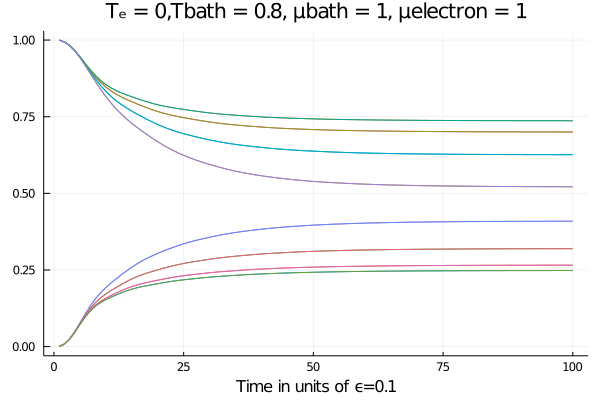

In [20]:
b2=[]
boxinitindex
testrange
list=[1 10]
for m=1:length(V_ph)
    b = Array{ComplexF64}(undef,testrange)
    for i=1:testrange
        #b[i] = Gᴿmatrix[m][i,1]
        b[i] = (imag(Gᴷmatrix[m][i,i])+1)*0.5
        #b[i] = Gᴷmatrix[m][i,i]
    end
    push!(b2,b)
end

b2
ser = collect(1:testrange)
p=plot(ser,real.(b2),legend=false,xlabel="Time in units of ϵ=$(h)",title = "Tₑ = $(Tₑ),Tbath = $(Temp_bath), μbath = $(μbath), μelectron = $(μ)",lw=1) 
## label="Tbath = $(Temp_bath)"
#scatter(ser,real.(b2[9]),legend=false)
#scatter(ser,real.(b2[3]),title="highest level",legend=false)


#  (non)- Computation of renormalized energies

 I'm using this transformation:

[treansformation.png](attachment:treansformation.png)

add a ! in from the [trans.... ] to see the picture

https://github.com/JuliaMath/QuadGK.jl/pull/44

# Comparison with thermal distribution

In [21]:
# #scatter!([75.],[fermi(ϵₑ(2),Temp_bath,μbath)])

# for k=1:length(V_ph)
#    scatter!([testrange],[fermi(RenomEn[k],Temp_bath,μbath)],xlabel="Time in units of step size", ylabel="n_k(t)",
#         title="Tₑ = $(Tₑ),Tbath = $(Temp_bath), μbath = $(μbath), μelectron = $(μ), Step size = $(h), 
#         Total time = $(h)*$(testrange)",titlefontsize=10)
# end
# current()

### Wrong: The spectral function doesn't have spikes and hence there's no sense of taking about "renormalized energies".

In [22]:
energyrange=[]
for k=1:length(V_ph)
    push!(energyrange,ϵₑ(k))
end

occupations= Array{ComplexF64,2}(undef,length(V_ph),testrange)
for i=1:testrange
    for j=1:length(V_ph)
        occupations[j,i]= (imag(Gᴷmatrix[j][i,i])+1)*0.5
    end
end


In [23]:
quadtest(x,en) = (1/π)*fermi(x,Temp_bath,μbath)*(λ^2)*(J(x))*( 1/( (x-en)^2 + (λ^2*J(x))^2 ) )

function newres(e,hop)
    return quadgk(t->quadtest(t,e),-2*hop,2*hop)
end

newoccu=[]

for k=1:length(V_ph)
   val = newres(ϵₑ(k),tB)[1]
   push!(newoccu,val) 
end

In [24]:
#fermi(μbath,Temp_bath,μbath)

In [25]:
#newres(μbath)

In [26]:
# scatter(energyrange,real.(occupations[:,1]),label="system distribution at t=0")
# #scatter!(energyrange,real.(occupations[:,5]))
# #scatter!(energyrange,real.(occupations[:,10]))
# #scatter!(energyrange,real.(occupations[:,20]))


@manipulate for o=1:testrange
    plot(energyrange,real.(occupations[:,o]),xlabel="System energies",ylabel="Occupation nk",title="Tₑ = $(Tₑ),Tbath = $(Temp_bath), μbath = $(μbath), μelectron = $(μ), Step size = $(h), 
           Total time = $(h)*$(testrange), bath bandwidth=$(tB)",titlefontsize=10,label="distribution at t=$(o*h)s",lw=3,markershape=:circle)
     vline!([μbath],label="bath μ = $(μbath)",lw=2)
    plot!(energyrange,newoccu,markershape=:hexagon,label="thermal distribution",size=(700,500))
end


    # do something with a, b, etc...
#     scatter(energyrange,real.(occupations[:,1]),label="system distribution at t=0")
#         plot(energyrange,real.(occupations[:,m]),xlabel="System energies",ylabel="Occupation nk",title="Tₑ = $(Tₑ),Tbath = $(Temp_bath), μbath = $(μbath), μelectron = $(μ), Step size = $(h), 
#           Total time = $(h)*$(testrange)",titlefontsize=10,label="Long time distribution(from evolution)",lw=3)
#     vline!([μbath],label="bath μ = $(μbath)",lw=2)
#     scatter!(energyrange,newoccu,markershape=:hexagon,label="thermal distribution",size=(700,500))
#     plot!(energyrange,newoccu,markershape=:hexagon,label="thermal distribution",size=(700,500))



# plot!(energyrange,real.(occupations[:,testrange]),xlabel="System energies",ylabel="Occupation nk",title="Tₑ = $(Tₑ),Tbath = $(Temp_bath), μbath = $(μbath), μelectron = $(μ), Step size = $(h), 
#           Total time = $(h)*$(testrange)",titlefontsize=10,label="Long time distribution(from evolution)",lw=3)

# #vline!([μ],label="system μ =$(μ)",lw=2)
#  vline!([μbath],label="bath μ = $(μbath)",lw=2)


# scatter!(energyrange,newoccu,markershape=:hexagon,label="thermal distribution",size=(700,500))
# plot!(energyrange,newoccu,markershape=:hexagon,label="thermal distribution",size=(700,500))

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["o"], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 100,:min => 1,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing),"index" => (Observable{Int64} with 2 listeners. Value:
50, nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "/Users/gurukalyanjayasingh/.julia/packages/Knockout/IP1uR/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/Users/gurukalyanjayasingh/.julia/packages/Knockout/IP1uR/src/../assets/knockout_punches.js"), Asset("js", nothing, "/Users/gurukalyanjayasingh/.julia/packages/InteractBase/Zfu5P/src/../assets/all.js"), Asset("css", nothing, "/Users/gurukalyanjayasingh/.julia/packages/InteractBase/Zfu5P/src/../assets/style.css"), Asset("css", nothing, "/Users/gurukalyanjayasingh/.julia/packages/Interact/SbgIk/src/../assets/bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set{AbstractConnection}(), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x000000011ef246d0, Task (runnable) @0x000000011ef246d0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\",\"9\",\"10\",\"11\",\"12\",\"13\",\"14\",\"15\",\"16\",\"17\",\"18\",\"19\",\"20\",\"21\",\"22\",\"23\",\"24\",\"25\",\"26\",\"27

In [27]:
#savefig("Aug2-2")

# A huge block of code - Don't mess with it

In [104]:
hope=nothing #ok, I didn't realize that line was neitzschean
hope=[]
for tB=2:5*1e-1:20

    J(ω) = (2/tB)*sqrt( 1- (ω/(2*tB))^2 ) 


    function quadgk_cauchy(f, a, c, b)
      fc = f(c)
      g(x) = (f(x) - fc) / (x - c)
      return quadgk(g, a, c, b)[1] + fc * log(abs((b - c)/(a - c)))
    end

    test(a) =-(λ^2)*J(a)*(1/(2*π))


    function reΣ(x)
        if -2*tB<x<2*tB
            return quadgk_cauchy(test, -2*tB, x, 2*tB)

        else
            test2(a,x ) = -(λ^2)*J(a)*(1/(2*π))*(1/(a-x))
            return quadgk(t->test2(t,x), -2*tB,2*tB)[1]
        end
    end

    function imΣ(ω)
        if abs(ω)<=2*tB
            return -1*(λ^2)*J(ω)*(1/2)
        else
            return 0
        end
    end
    #imΣ(ω) = -1*(λ^2)*J(ω)*(1/2)


    function real_sigmar(t)
        makeshift(ω) = -im*reΣ(ω)*sin(ω*t)*(1/(2*π))
        return quadgk(makeshift,-200*tB,200*tB)[1]
    end


    function Σᴿ(t1,t2) 
        if t1>t2
            sum1= -im*(λ^2)*(1)*(1/(tB))*( besselj1(2*tB*abs(t1-t2)*h) / (abs(t1-t2)*h ) )
            return sum1
        else
            return 0
        end
    end


    #-im*(λ^2)*(1)*(1/(tB))*(besselj1(2*tB*abs(t1-t2)*h)/(abs(t1-t2)*h))*(t1>t2)

    σᴷ(ω) = -im*(λ^2)*J(ω)*tanh((ω-μbath)/(2*Temp_bath))

    function Σᴷ(t1,t2)
        dω=(1/10000)*4*tB
        steps = collect(-2*tB:dω:2*tB)
        result=0
        for ω in steps
            result = result + dω*σᴷ(ω)*exp(-im*ω*(t1-t2)*h)
        end
        return result/(2*π)
    end

    matinit()
    boxinit()

    ### Code to update the Sigma R, Sigma K matrix

    for i=1:testrange+10
        Σₑᴿ[i,1] = Σᴿ(i,1)
    end

    for j=2:testrange+10
        for i=j:testrange+10
            Σₑᴿ[i,j] = Σₑᴿ[i-j+1,1]
        end
    end

    for i=1:testrange+10
        Σₑᴷ[i,1] = Σᴷ(i,1)
    end

    for i=1:testrange+10
        Σₑᴷ[1,i] = Σᴷ(1,i)
    end

    for j=1:testrange+10
        for i=j:testrange+10
            Σₑᴷ[i,j] = Σₑᴷ[i-j+1,1]
        end
    end

    for j=1:testrange+10
        for i=j:testrange+10
            Σₑᴷ[j,i] = Σₑᴷ[1,i-j+1]
        end
    end


    ####### Gr evolution #########

    for i=boxinitindex:testrange     ### The diagonal value #should probably start from 2
        # Update GR, GK edges
        for k = 1 : length(V_ph)
            for j=1:i
                bessellimit = -im*(λ^2)*(1)#*(1)*(1/(tB))*2*tB*(1/2)# *(besselj1(2*tB*abs(t1-t2)*h)/(abs(t1-t2)*h))
                endpoint = (h/2)* G₀ᴿ(k,i+1,i+1)*bessellimit*(h/2)
                endpnt = 1/(1-endpoint)
                Gᴿmatrix[k][i+1,j] = ( im*G₀ᴿ(k,i+1,i)*Gᴿmatrix[k][i,j]+ (h/2)* G₀ᴿ(k,i+1,i)*(Fₑ(k,i,j) + (h/2)*bessellimit*Gᴿmatrix[k][i,j] ) + (h/2)* G₀ᴿ(k,i+1,i+1)*Fₑ(k,i+1,j) )*endpnt

            end
        end
    end


    for i=boxinitindex:testrange     ### The diagonal value #should probably start from 2

        # Update GR, GK edges
        for k = 1 : length(V_ph)
            for j=1:i
                bessellimit = -im*(λ^2)*(1) #*(1)*(1/(tB))*2*tB*(1/2)# *(besselj1(2*tB*abs(t1-t2)*h)/(abs(t1-t2)*h))
                endpoint = (h/2)* G₀ᴿ(k,i+1,i+1)*bessellimit*(h/2)
                endpnt=1/(1-endpoint)
                Gᴷmatrix[k][i+1,j] = (im*G₀ᴿ(k,i+1,i)*Gᴷmatrix[k][i,j]+ (h/2) * G₀ᴿ(k,i+1,i) * ( RKₑ(k,i,j)+ h/2*bessellimit*Gᴷmatrix[k][i,j] + KAₑ(k,i,j) )+ (h/2) * G₀ᴿ(k,i+1,i+1) * ( RKₑ(k,i+1,j) + KAₑ(k,i+1,j) ) )*endpnt
                Gᴷmatrix[k][j,i+1] = - conj(Gᴷmatrix[k][i+1,j]) # iGᴷ is hermitian  ⟹ iGᴷ(1,2) = conj((iGᴷ(2,1)) ⟹ Gᴷ(1,2) = - conj(Gᴷ(2,1))
            end
        end

        ############## Diagonal terms update #############
        #Update GK(t+ϵ,t+ϵ) i.e GK(i+1,i+1) here  - needs Σₑᴿ on the i+1 block edges  i.e.
        for k=1:length(V_ph)
            bessellimit = -im*(λ^2)*(1)#*(1)*(1/(tB))*2*tB*(1/2)# *(besselj1(2*tB*abs(t1-t2)*h)/(abs(t1-t2)*h))
            endpoint = (h/2)* G₀ᴿ(k,i+1,i+1)*bessellimit*(h/2)
            endpnt=1/(1-endpoint)
            Gᴷmatrix[k][i+1,i+1] = (im*G₀ᴿ(k,i+1,i)*Gᴷmatrix[k][i,i+1]+ (h/2)*G₀ᴿ(k,i+1,i)*(RKₑ(k,i,i+1)+h/2*bessellimit*Gᴷmatrix[k][i,i+1] + KAₑ(k,i,i+1))+ (h/2) * G₀ᴿ(k,i+1,i+1) * ( RKₑ(k,i+1,i+1) + KAₑ(k,i+1,i+1) ) )*endpnt
        end 
    end

    occupations= Array{ComplexF64,2}(undef,length(V_ph),testrange)
    for i=1:testrange
        for j=1:length(V_ph)
            occupations[j,i]= (imag(Gᴷmatrix[j][i,i])+1)*0.5
        end
    end

    quadtest(x,en) = (1/π)*fermi(x,Temp_bath,μbath)*(λ^2)*(J(x))*( 1/( (x-en)^2 + (λ^2*J(x))^2 ) )

    function newres(e,hop)
        return quadgk(t->quadtest(t,e),-2*hop,2*hop)
    end

    newoccu=[]

    for k=1:length(V_ph)
       val = newres(ϵₑ(k),tB)[1]
       push!(newoccu,val) 
    end

    scatter(energyrange,real.(occupations[:,testrange]),label=false,title="bath bandwidth=$(tB)")  #xlabel="System energies (ϵ)",ylabel="Occupation n(ϵ)",title="Tₑ = $(Tₑ),Tbath = $(Temp_bath), sysbathcoupling = $(λ), μbath = $(μbath), μelectron = $(μ), Step size = $(h), 
          # Total time = $(h)*$(testrange), bath bandwidth=$(tB)",titlefontsize=10,lw=3,markershape=:circle)
    vline!([μbath],label="bath μ = $(μbath)",lw=2)
    push!(hope,plot!(energyrange,newoccu,markershape=:hexagon,label=false))
    
    #plot(energyrange,real.(occupations[:,o]),xlabel="System energies",ylabel="Occupation nk",title="Tₑ = $(Tₑ),Tbath = $(Temp_bath), μbath = $(μbath), μelectron = $(μ), Step size = $(h), 
           #Total time = $(h)*$(testrange), bath bandwidth=$(tB)",titlefontsize=10,label="distribution at t=$(o*h)s",lw=3,markershape=:circle)
    
end

In [29]:
# savefig("aug2-11-12")

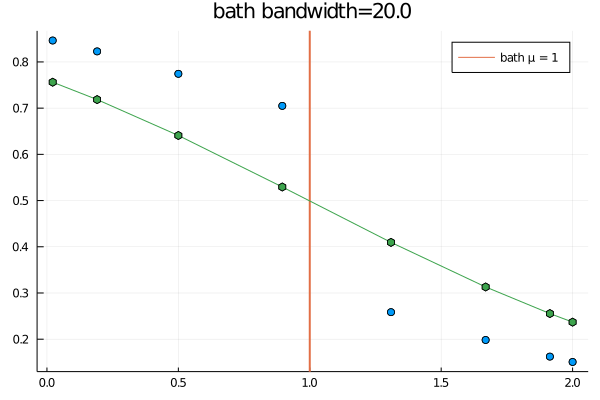

In [116]:
hope[37]

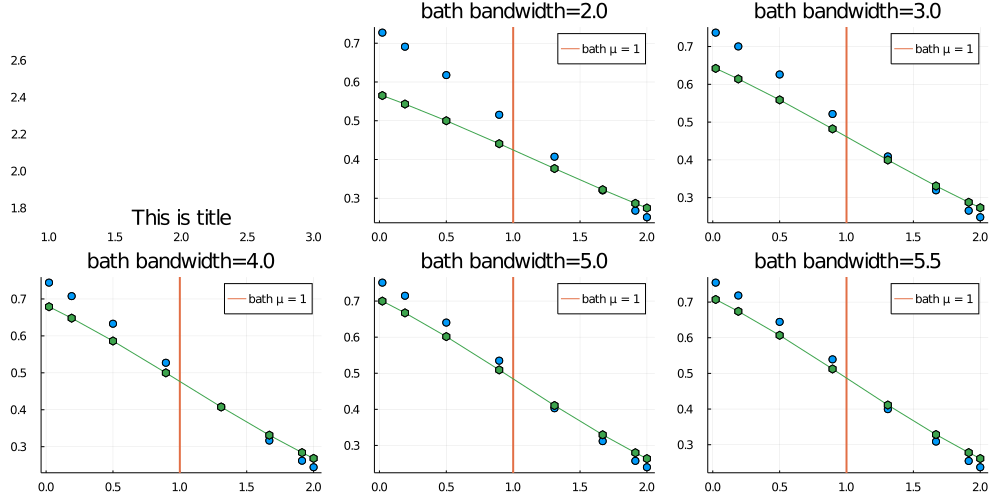

In [76]:
plot(hope[1],hope[3],hope[5], hope[7],hope[8], layout=5,size=(1000,500) )#, title=" Tₑ = $(Tₑ),Tbath = $(Temp_bath), sysbathcoupling = $(λ), μbath = $(μbath), μelectron = $(μ), Step size = $(h), 
           #Total time = $(h)*$(testrange)")

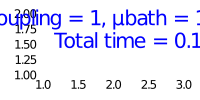

In [89]:
 y= ones(3) 
titletest = Plots.scatter(y, marker=0,markeralpha=0, annotations=(2,1.75 , Plots.text("Tₑ = $(Tₑ), Tbath = $(Temp_bath), sysbathcoupling = $(λ), μbath = $(μbath), μelectron = $(μ), Step size = $(h), 
           Total time = $(h)*$(testrange)",:blue)),axis=false, grid=false, leg=false,size=(200,100))

In [ ]:
"Tₑ = $(Tₑ),Tbath = $(Temp_bath), sysbathcoupling = $(λ), μbath = $(μbath), μelectron = $(μ), Step size = $(h), 
           Total time = $(h)*$(testrange)"

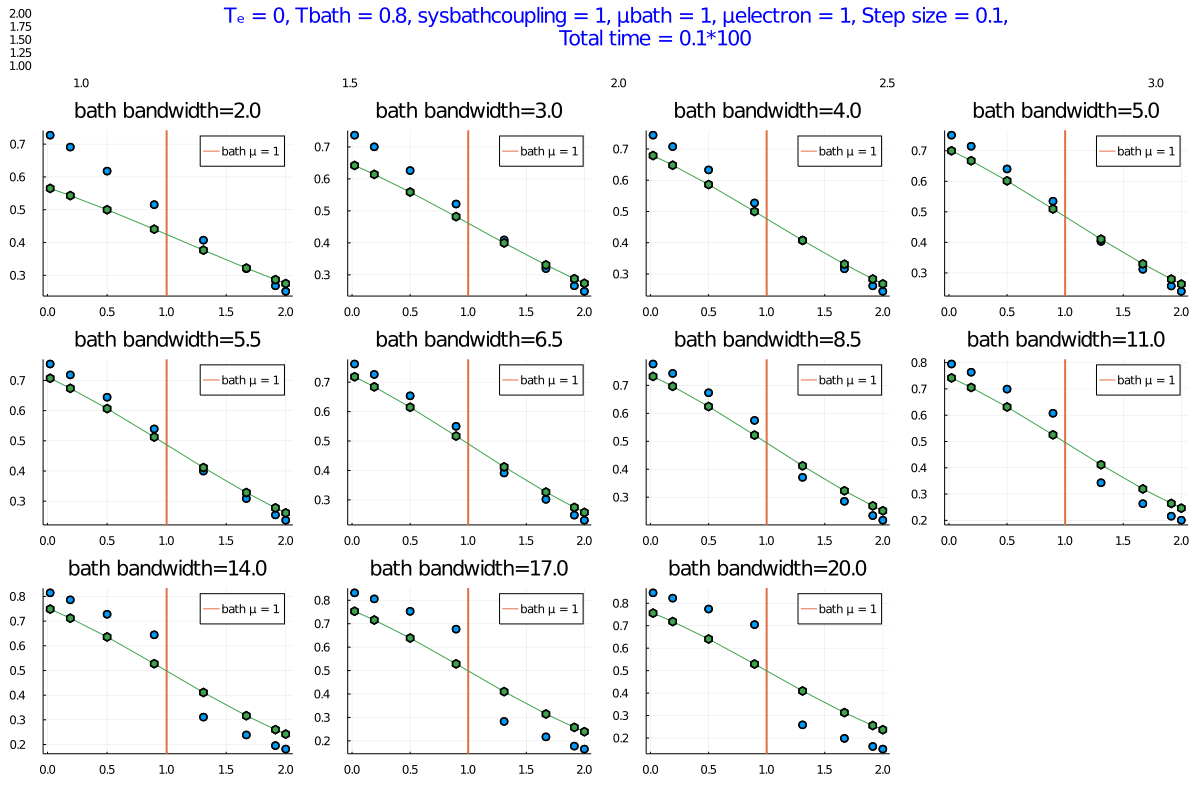

In [127]:
Plots.plot(
    titletest,
    plot(hope[1],hope[3],hope[5], hope[7],hope[8],hope[10], hope[14] ,hope[19],hope[25],hope[31],hope[37],layout=11,size=(1200,800) ),
    layout=grid(2,1,heights=[0.08,0.9])
)

In [128]:
savefig("bathbandiwidth_variation")

In [101]:
hope

21-element Array{Any,1}:
 Plot{Plots.GRBackend() n=3}
 Plot{Plots.GRBackend() n=3}
 Plot{Plots.GRBackend() n=3}
 Plot{Plots.GRBackend() n=3}
 Plot{Plots.GRBackend() n=3}
 Plot{Plots.GRBackend() n=3}
 Plot{Plots.GRBackend() n=3}
 Plot{Plots.GRBackend() n=3}
 Plot{Plots.GRBackend() n=3}
 Plot{Plots.GRBackend() n=3}
 Plot{Plots.GRBackend() n=3}
 Plot{Plots.GRBackend() n=3}
 Plot{Plots.GRBackend() n=3}
 Plot{Plots.GRBackend() n=3}
 Plot{Plots.GRBackend() n=3}
 Plot{Plots.GRBackend() n=3}
 Plot{Plots.GRBackend() n=3}
 Plot{Plots.GRBackend() n=3}
 Plot{Plots.GRBackend() n=3}
 Plot{Plots.GRBackend() n=3}
 Plot{Plots.GRBackend() n=3}

In [33]:
hope[1]

LoadError: [91mBoundsError: attempt to access 0-element Array{Any,1} at index [1][39m

 How the thermal distribution changes with $tB$?

In [34]:

# J₂(ω,hop)=(2/hop)*sqrt( 1- (ω/(2*hop))^2 ) 

# test₂(x,en,hop) = (1/π)*fermi(x,Temp_bath,μbath)*(λ^2)*(J₂(x,hop))*(1/((x-en)^2+(λ^2*J₂(x,hop))^2 ) )

# # quadtest(x,en) = (-1/π)*fermi(x,Temp_bath,μbath)*imΣ(x)*(1/((x-en-reΣ(x))^2+imΣ(x)^2 ) )




# function resnew(e,hop)
#     return quadgk(t->test₂(t,e,hop),-2*hop,2*hop)
# end




# # newoccu=[]

# # for k=1:length(V_ph)
# #    val = newres(ϵₑ(k),tB)[1]
# #    push!(newoccu,val) 
# # end

# values=collect(1:1000)


# for hop in values
#     occu=[]
#     for k=1:length(V_ph)
#        val = resnew(ϵₑ(k),hop)[1]
#        push!(occu,val) 
#     end
#     if hop==1000
#         scatter!(energyrange,occu,label="$(hop)",legend=false,markershape=:hexagon,markersize=15)
#     elseif hop==50
#         #scatter!(energyrange,occu,label="$(hop)",legend=false,markershape=:star,markersize=10)
#     else
#         plot!(energyrange,occu,label="$(hop)",legend=false)
#     end
    
# end
    
# current()


## Correlators

Now I calculate the correlators

## Dispersion 

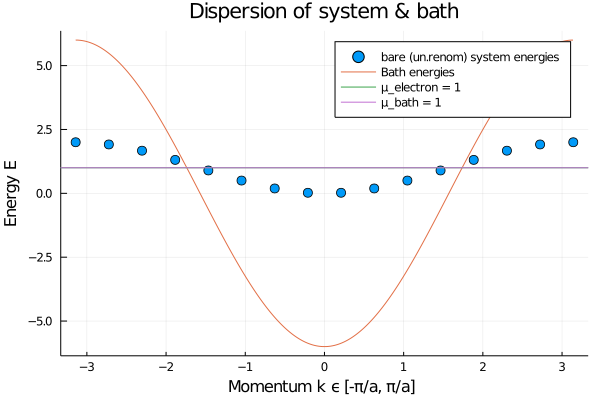

In [129]:
disp_electron= []
for m=1:length(V_ph)
    push!(disp_electron,ϵₑ(m))
end
disp_electron

x=collect(-π/a1:a2:π/a1)

scatter(x,disp_electron,label="bare (un.renom) system energies",markersize = 5,ylabel="Energy E")
plot!(collect(-π/a1:1e-2:π/a1), 2*-tB*cos.(collect(-π/a1:1e-2:π/a1).*a1),title = "Dispersion of system & bath",label="Bath energies",xlabel="Momentum k ϵ [-π/a, π/a] ")
hline!([μ],label = "μ_electron = $(μ)")
hline!([μbath],label = "μ_bath = $(μbath)")

In [131]:
tB
# savefig("newdispersion")

3

Bath Badwidth, (s)=2.0x2

System Bath Coupling=1.0

Initial Energy Level=0.5

Initial Chem pot= -1 for blue, green, 1 for orange and yellow

Initial Temp=0.0

Bath Chem Pot= various as indicated

Bath Temp=various as indicated (0.0, 0.5, 1.0, 1.5)

Bath Spectral Function J(w)=2/s (sqrt(1-(w/2s)^2));


How Do i Understand what's the dependence of $\mu_{bath}$, $\mu_{system}$ and their respective temperature on thermalisation?

I hope you are comparing with thermal n_k = \int_{-2t_B} ^{2t_B} d \omega [ (-1/\pi) Im [ 1/[\omega- \epsilon_k -\Sigma^R(\omega) ]  ]]  [ 1/(exp((\omega -\mu)/T)+1)]

$n_k = \int_{-2t_B} ^{2t_B} d \omega [ (-1/\pi) Im [ 1/[\omega- \epsilon_k -\Sigma^R(\omega) ]  ]]  [ 1/(exp((\omega -\mu)/T)+1)]$

### The end

Here I'm checking the behaviour of the equation $\omega-\epsilon(k)-\Sigma(\omega)$

### Things I learned while coding and from discussions
- Adding a bath to your system can make the idea of "quasi-particle" itself shady if the spectral function isn't a spikey one.
- When the spectral function has a spread, then you must never interpret excitations as "new particles with renormlaized energies": same as pnt1, there's no strict sense of what a quasiparticle is
- If in doubt, plot $Im(G^R(k,\omega)$ out - it'll act like dos

In [37]:
# spectral(x)=imΣ(x)*(1/((x-ϵₑ(25)-reΣ(x))^2+imΣ(x)^2 ) )*(-1/π)

# testom=collect(-2*tB:1e-1:2*tB)
# plot(testom, spectral.(testom))


# codespect=[]

# function sp(ω,k)
#     sum=0
#     for i=1:N𝑡
#         sum = sum + Gᴿmatrix[k][i,1]*exp(im*ω*(i-1)*h)*h
#     end
#     return imag(sum)*(-1/π)
# end

# omval=collect(-5*tB:1e-1:5*tB)
# plot!(omval,sp.(omval,25),title="Plot of Im[Gʳ(ϵ,ω)] vs ω")


### re $\Sigma$ - what does it do?


In [38]:
# function J(t)
#     if t>=0
#         δ=1e-2
#         sample=collect(-2*tB:δ:2*tB)
#         sum=0
#         for ω in sample
#             sum=sum+δ*J(ω)*exp(-im*ω*t)
#         end
#         return im*sum*(1/(2*π))
#     else
#         return 0
#     end
# end

In [39]:
# storage=[]

# for i in -1000*tB:1e-1:1000*tB
#     val=reΣ(i)
#     push!(storage,val)
# end

In [40]:
# for i in collect(-2:1e-1:0)
#     println(i)
# end
# # for i in -2:1e-1:0
# #     println(i)
# # end

In [41]:
# storage2=[]
# T=50
# for time=1:1e-1:T
#     result=0
#     i=1
#     for ω in -1000*tB:1e-1:1000*tB
#         result=result+storage[i]*exp(-im*ω*time)*(1/(2*π))*1e-1 
#         i=i+1
#     end
#     push!(storage2,result)
# end

In [42]:
# #storage2
# plot(collect(1:1e-1:T), imag.(storage2) ,label="from reΣ")
# plot!(collect(1:1e-1:T),imag.(realJ.( collect(1:1e-1:T) ) ) ,label="from J")
# plot!(collect(1:1e-1:T),imag.(Σᴿ.( collect(1:1e-1:T),0 ) ) ,label="from paper",xlabel="Time")

Ok. So **principal** value shouldn't be treated lightly.

In [43]:
# plot(collect(-5*tB:1e-1:5*tB),imΣ.(collect(-5*tB:1e-1:5*tB)))
# plot!(collect(-5*tB:1e-1:5*tB),reΣ.(collect(-5*tB:1e-1:5*tB)))

In [44]:
# Σᴿ(1e-8,0)

$Gᴿmatrix [k] [i+1,j] = ( im * G₀ᴿ(k,i+1,i)*Gᴿmatrix [k] [i,j]+ (h/2)* G₀ᴿ(k,i+1,i)*(Fₑ(k,i,j)) + (h/2)* G₀ᴿ(k,i+1,i+1)*Fₑ(k,i+1,j) )*endpnt$

In [45]:
# function A(x,en)
#     if abs(x)<=2*tB
#         return (1/π)*(λ^2)*(J(x))*( 1/( (x-en)^2 + (λ^2*J(x))^2 ) )
#     else
#         return 0
#     end
# end

In [46]:
# plot(collect(-5*tB:1e-2:5*tB),A.(collect(-5*tB:1e-2:5*tB),-1))

In [47]:
# @manipulate for ϵ=-2*tB:1e-2:2*tB #, var2=<object>, etc...
#     # do something with a, b, etc...
#     xaxis =collect(-5*tB:1e-2:5*tB)
#     list = A.(collect(-5*tB:1e-2:5*tB),ϵ)
#     plot(xaxis,list,xlabel="ω")
#     vline!([ϵ],label="ϵ",title="Plot of im(Gʳ(ϵ,ω)) vs ω")
#     vline!([2*tB -2*tB], label=["2*tb" "-2tB"])
# end
